In [1]:
import sympy as sp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import multimode_systems.architecture_optimizer_new as arch_opt
import multimode_systems.constraints as msc
import multimode_systems.symbolic as sym

In the previous notebook we have found valid graphs for a directional coupler. In the following, we want to analyse and generalise these solutions, exemplarily for the graph:

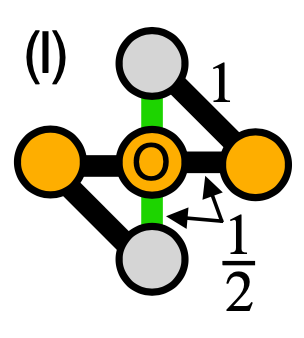

Our code saves graphs as a list of integers. This list contains represents the upper triangular matrix of the adjugate matrix. 0 corresponds to no coupling, 1 to a real coupling, 2 to a complex coupling.

The graph above corresponds to the list [0,0,1,0,1,0,1,1,0,0,2,2,0,0,0]

This represents the adjugate matrix:
$\begin{pmatrix}
0&0&1&0&1\\0&0&1&1&0\\1&1&0&2&2\\0&1&2&0&0\\1&0&2&0&0
\end{pmatrix}
$

As our graphs are undirectional, only the upper triangular matrix is required to characterise the graph

In [46]:
graph_to_test = np.array([0,0,1,0,1,0,1,1,0,0,2,2,0,0,0])

t = sp.Symbol('t', real=True) # transmission rate
S_target = sp.Matrix([[0,0,0],[0,0,0],[t,t,0]])
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=2,
)

fully connected graph is a valid graph


Let us perform the continuous optimisation just for the graph above. The method repeated_optimization will try repeatitively try to find a solution for the specified graph. If not successful within a certain number of tries (by default 10), the method will return that the optimisation failed

In [3]:
success, infos, _ = optimizer.repeated_optimization(triu_matrix=graph_to_test, **optimizer.kwargs_optimization, **optimizer.solver_options)
print('optimisation was successful:', success)

optimisation was successful: True


The list infos contains information about all tries to find a solution. The last element corresponds to the solution where the loss was successfully minimized to zero.
Most importantly infos contains the found parameters, but also information about the optimisation, like the loss history

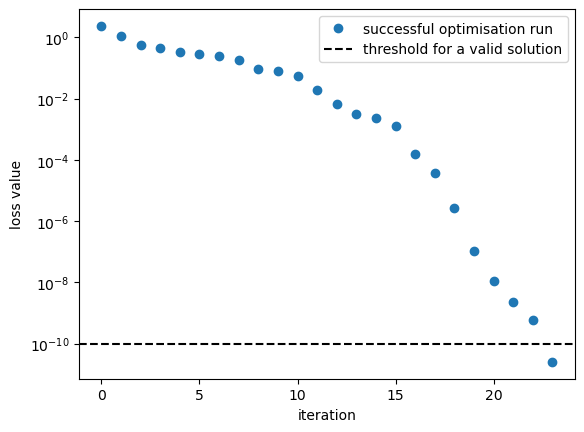

In [4]:
plt.semilogy(infos[-1]['loss_history'], marker='o', ls='None', label='successful optimisation run')
plt.axhline(optimizer.kwargs_optimization['max_violation_success'], color='black', ls='dashed', label='threshold for a valid solution')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.legend()

Show the solution for the found dimensionless parameter values.
Please note the indexing convention: Mode 0 and Mode 1 are the input modes, mode 2 the output mode, mode 3 and 4 are auxiliary modes

In [5]:
infos[-1]['solution_dict']

{'gabs02': -0.35355338669642977,
 'gabs12': 0.3535545692314491,
 'gabs13': -0.5000006972544462,
 'gabs23': -0.3535546075521956,
 'gabs04': -0.5000032870173376,
 'gabs24': -0.35355319438571114,
 'gphase23': 1.5707990216660364,
 'gphase24': -1.5707995621471118,
 'gauge0': 0.9503780075504532,
 'gauge1': -2.1912171422540148,
 'gauge2': -0.6204211949270292,
 't': 0.7071069989155087}

Or the more compressed information required for the following analysis: The cooperativities and the value for the transmission rate. It is easy to see, that the transmission rate equals 1/sqrt(2) and that the cooperativites are either 1 or 1/2.

In [6]:
infos[-1]['parameters_for_analysis']

{'C02': 0.4999999889780608,
 'C04': 1.0000131481125685,
 'C12': 0.5000033336977422,
 'C13': 1.0000027890197294,
 'C23': 0.5000034420855481,
 'C24': 0.4999994450413618,
 't': 0.7071069989155087}

Let's generalise our findings. Inspecting our graph, we note that it can be viewed as the combination of two isolator graphs. This inspires a general ansatz for an $N_\mathrm{in}$-port coupler: a graph that comprises an isolator building block for each input port

target scattering matrix for 4 inputs:


<IPython.core.display.Math object>

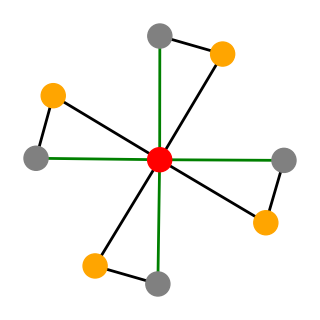

In [74]:
def generate_target_scattering_matrix(num_input_ports):
    '''
    generates the target scattering matrix for a directional coupler with num_input_ports inputs and 1 output port
    it will keep the convention, that mode 0 up to mode num_input_ports-1 will be the input ports, mode num_input_ports will be the output port
    '''
    t = sp.Symbol('t', real=True)
    S_target = sp.zeros(num_input_ports,num_input_ports+1)
    S_target = S_target.row_insert(num_input_ports, sp.Matrix([[t]*num_input_ports+[0]]))
    return S_target

def generate_graph_list(num_input_ports):
    '''
    generates the target scattering matrix for a directional coupler with num_input_ports inputs and 1 output port
    it will keep the convention, that mode 0 up to mode num_input_ports-1 will be the input ports, mode num_input_ports will be the output port, the remaining modes are the auxiliary modes
    '''
    num_modes = 2*num_input_ports + 1
    adjugate_matrix = np.zeros([num_modes, num_modes], dtype='int8')
    output_idx = num_input_ports
    for input_idx in range(num_input_ports):
        auxiliary_idx = num_input_ports + input_idx + 1
        adjugate_matrix[input_idx, auxiliary_idx] = adjugate_matrix[auxiliary_idx, input_idx] = 1 # coupling between input and auxiliary mode is a real coupling
        adjugate_matrix[input_idx, output_idx] = adjugate_matrix[output_idx, input_idx] = 1 # coupling between input and output mode is a real coupling
        adjugate_matrix[output_idx, auxiliary_idx] = adjugate_matrix[auxiliary_idx, output_idx] = 2 # coupling between output and auxiliary mode is a complex coupling
    
    triu_indices = np.triu_indices(num_modes)
    return adjugate_matrix[triu_indices]

num_input_ports = 4
S_target = generate_target_scattering_matrix(num_input_ports)
graph_to_test = generate_graph_list(num_input_ports)
node_colors = ['orange']*num_input_ports + ['red'] + ['gray']*num_input_ports
print('target scattering matrix for %i inputs:'%num_input_ports)
sym.render(S_target)
plt.figure(figsize=(3,3))
msc.plot_graph(triu_matrix=graph_to_test, node_colors=node_colors)

In [75]:
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=num_input_ports,
    make_initial_test=True,
    kwargs_optimization={'num_tests': 100}, # increase number of tests to 20 (default: 10)
    solver_options={'maxiter': 5000} # increase the maximum number of iterations (default: 200)
)

success, infos, _ = optimizer.repeated_optimization(triu_matrix=graph_to_test, **optimizer.kwargs_optimization, **optimizer.solver_options)
print('optimisation was successful:', success)

fully connected graph is a valid graph
optimisation was successful: True


In [43]:
infos[-1]['parameters_for_analysis']

{'C04': 0.25000136547620455,
 'C05': 1.0000018009949487,
 'C14': 0.24999920474579074,
 'C16': 0.9999999239876872,
 'C24': 0.24999918846989244,
 'C27': 1.0000004899883081,
 'C34': 0.24999973234003472,
 'C38': 0.9999997548310787,
 'C45': 0.25000159325546095,
 'C46': 0.25000034509938923,
 'C47': 0.2499995844899896,
 'C48': 0.2499999180542854,
 't': 0.5000006280200249}

Let's analyse the parameters systematically

In [76]:

num_input_ports = 4
S_target = generate_target_scattering_matrix(num_input_ports)
graph_to_test = generate_graph_list(num_input_ports)

optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=num_input_ports,
    make_initial_test=False, # skip the test of the fully connected graph to save some time
    kwargs_optimization={'num_tests': 30}, # increase number of tests to 20 (default: 10)
    solver_options={'maxiter': 2000} # increase the maximum number of iterations (default: 200)
)

success, infos, _ = optimizer.repeated_optimization(triu_matrix=graph_to_test, **optimizer.kwargs_optimization)

In [79]:
sp.Symbol('C_%i,%i'%(1,2))

C_1,2

In [80]:
optimizer.mode_types

[True, True, True, True, True, True, True, True, True]